## Kalman filter with 1-dimension observation and 1-dimension state vector for "random walk plus noise" model

In this notebook, we are going to:

a) generate simulations using "random walk plus noise" model

b) calibrate Kalman filter parameters to distill true signals from observations with noise

c) check whether Kalman filter prediction is better than simple "last-observation" prediction

---------------

Let's start with the theory. 

We assume that we have the following data:

* we have true signal $\theta_t$ which is unobservable. The transition equation is: $\theta_t = \theta_{t-1} + w_t$ where $w_t \sim N(0, \sigma_w^2) $

* we have observations $x_t$ which equal to the sum of signal $\theta_t$ and noise $n_t$. The observation equation is: $x_t = \theta_{t} + n_t $ where $n_t \sim N(0, \sigma_n^2) $

So, we have some true signal $\theta_t$ which is unobserved and we don't know it. However, we observe $x_t$ values but they contain noise $n_t$.

Having only observed values $x_t$, we would like to find best estimations of unobserved $\hat\theta_t$. Estimated $\hat\theta_t$ can be used for forecasting of future $x_t$ values.

-------------------------------------------

The **algorithm** is the following:

1) **Initialize values**. We assign values to the following variables:

    * $ P_{0} = 1 $ for initial value of $\hat \theta_t $ variance-covariance matrix

    * $ \hat\theta_{0} = x_0 $

2) **Prediction stage**. First, we forecast $\theta_t$ having only t-1 information. Second, we update variance-covariance matrix prediction for time t having only t-1 information:

    * $\hat \theta_{t|t-1} = \hat \theta_{t-1}$. Best prediction for $\theta_t$ from timestep t-1 is the last predicted $\hat \theta_{t-1}$ value because $\theta_t = \theta_{t-1} + w_t$ and $E(w_t) = 0$

    * $ P_{t|t-1} = P_{t-1} + \sigma_w^2 $. We add $\sigma_w^2$ because on each step $\theta_t = \theta_{t-1} + w_t$

3) **Updating stage**. When we gain $x_t$ value at time t, we update the following values:

    * error $ e_t = x_t - \hat \theta_{t|t-1} $ is the difference between true $x_t$ value and our prediction $\hat \theta_{t|t-1}$ having only t-1 information

    * Kernel gain matrix $ K_t = P_{t|t-1} / (P_{t|t-1} + \sigma_n^2) $

    * $ \hat \theta_t = \hat \theta_{t|t-1} + K_t e_t $ means that signal $\theta_t$ is updated based on t-1 information prediction and error $e_t$

    * $ P_t = P_{t|t-1} - K_t P_{t|t-1} $ is the updated variance-covariance matrix of $ \hat \theta_t $

4) We repeat steps 1 and 2 until iteratively

P.S. Theoretical foundation of Kalman filter can be found in the book "Time Series Analysis" by C. Chatfield and H. Xing (Chapter 10, p.261)

---------------------

## a) Let's generate the simulations for "randow walk plus noise" model:

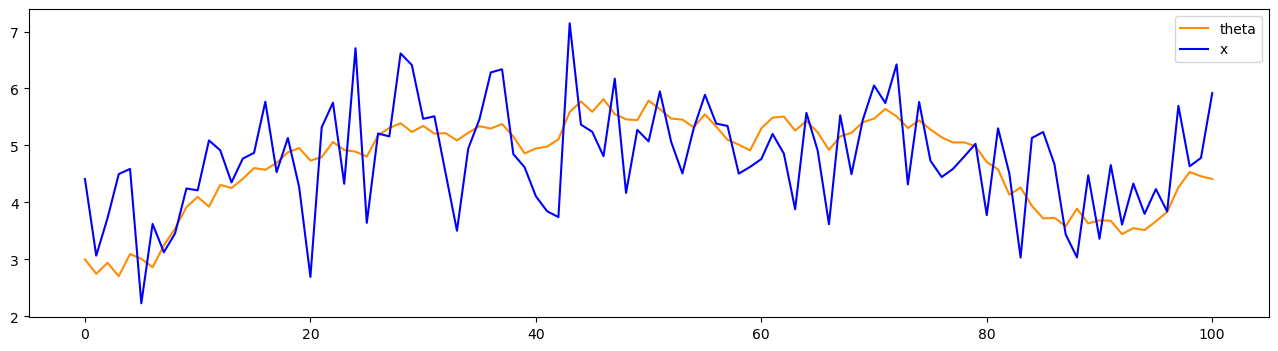

In [1]:

import numpy as np
import matplotlib.pyplot as plt

T_MAX = 100  # the number of the last time step of simulation paths (0, 1,...., t_max)
N_VOL = 0.8  # the vol of noise
W_VOL = 0.2  # the vol of signal theta
THETA0 = 3   # the initial point to generate simulations


def create_rw_plus_noise_sims(t_max, n_vol, w_vol, theta0, seed=None):
    """
    creates simulated theta and x paths of "random walk plus noise" model
    
    arguments:
        t_max - the number of the last time step of simulation paths (0, 1,...., t_max)
        n_vol - the vol of noise
        w_vol - the vol of signal theta
        theta0 - the initial point to generate simulations
        seed - the random number seed for random noise and signal vol values
    
    returns:
        theta - signals
        x - observations
    """

    if seed is not None:
        np.random.seed(seed)
    n = np.random.normal(0, n_vol, t_max + 1)  # noise values for each timestep
    w = np.random.normal(0, w_vol, t_max + 1)  # state vol values for each timestep

    theta = np.zeros(t_max + 1)  # state vectors m*1 size for each timestep
    theta[0] = theta0
    x = np.zeros(t_max + 1)
    x[0] = theta[0] + n[0]

    for i in range(1, t_max + 1):
        theta[i] = theta[i - 1] + w[i]
        x[i] = theta[i] + n[i]
    
    return theta, x


theta, x = create_rw_plus_noise_sims(t_max=T_MAX,
                                     n_vol=N_VOL,
                                     w_vol=W_VOL,
                                     theta0=THETA0,
                                     seed=0)
t_vals = np.arange(len(x))

plt.figure(figsize=(16,4))
plt.plot(t_vals, theta, label='theta', c='darkorange')
plt.plot(t_vals, x, label='x', c='blue')
plt.legend()
plt.show()

## b) let's calibrate Kalman filter parameters to distill true signals from observations with noise

Now let's use the algorithm above to calculate $\hat \theta_t$ - best estimations of true signals $\theta_t$

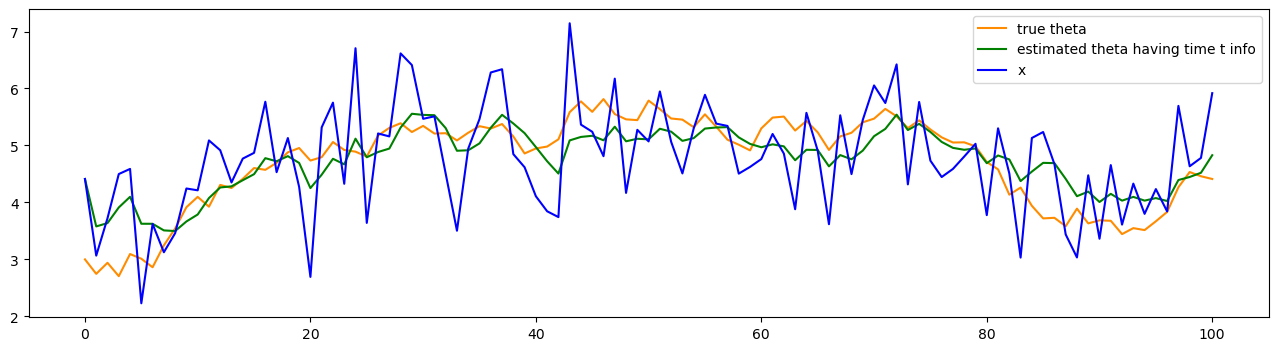

In [2]:

def calibrate_kalman_filter(x, n_vol, w_vol):
    """
    calculates estimations of signals theta_est and theta_est_t_1
    the calculatation are based on simulated observations x
    
    arguments:
        x - observations
        n_vol - the vol of noise
        w_vol - the vol of signal theta
    returns:
        theta_est - estimation of theta based on time t info
        theta_est_t_1 - estimation of theta based on time t-1 info
    """

    t_max = len(x)

    # Initialize values
    p = np.zeros(t_max)  # var-cov matrix of theta estimation
    p[0] = 1  # initial guess
    theta_est = np.zeros(t_max)  # estimation of theta based on time t info
    theta_est[0] = x[0]  # initial guess

    p_t_1 = np.zeros(t_max)  # var-cov matrix of theta estimation based on time t-1 info
    theta_est_t_1 = np.zeros(t_max)  # estimation of theta based on time t-1 info    
    e = np.zeros(t_max)  # estimation of noise
    k = np.zeros(t_max)  # Kalman gain matrix

    for t in range(1, t_max):
        # prediction stage
        theta_est_t_1[t] = theta_est[t - 1]
        p_t_1[t] = p[t - 1] + w_vol**2
        # updating stage
        e[t] = x[t] - theta_est_t_1[t]
        k[t] = p_t_1[t] / (p_t_1[t] + n_vol**2)
        theta_est[t] = theta_est_t_1[t] + k[t] * e[t]
        p[t] = p_t_1[t] - k[t] * p_t_1[t]
    
    return theta_est, theta_est_t_1


theta_est, theta_est_t_1= calibrate_kalman_filter(x=x,
                                                  n_vol=N_VOL,
                                                  w_vol=W_VOL
                                                  )

plt.figure(figsize=(16,4))
plt.plot(t_vals, theta, label='true theta', c='darkorange')
plt.plot(t_vals, theta_est, label='estimated theta having time t info', c='g')
plt.plot(t_vals, x, label='x', c='blue')
plt.legend()
plt.show()


As we can see, our estimations of true theta (green) are closer to true signals (orange) than observations. So, that's pretty good estimations of true signals $\theta_t$

## c) check whether Kalman filter prediction is better than simple "last-observation" prediction

The algorith above provides $\hat \theta_{t|t-1}$ values. They are best estimation of $x_t$ values having only t-1 information.

Let's figure out whether Kalman filter with these $\hat \theta_{t|t-1}$ predictions is better for 1-day prediction of x than simple last-x-value prediction:

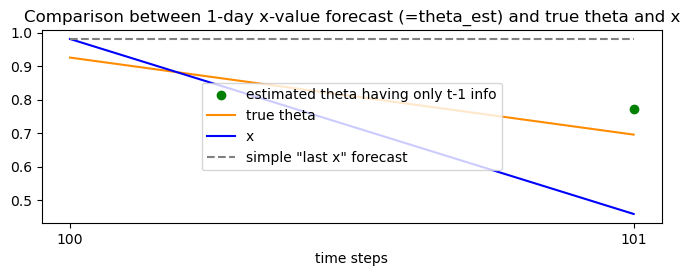

theta_est is a better than x_t for predicting x_t+1 values (better in 61.87 % of cases)


In [3]:
def predict_x_1_day_horizon(n_sims, t_max, n_vol, w_vol, theta0):
    """
    1) generate "random walk plus noise" x observations
    2) calculate estimations of theta using kalman filter
    3) checks whether Kalman filter prediction is better than simple "last-observation" prediction
    4) repeat steps 1-3 n_sims times to calculate average percent of cases 
    when Kalman filter prediction is closer to real x values than simple "last-observation" prediction
    
    arguments:
        x - observations
        t_max - the number of the last time step of simulation paths (0, 1,...., t_max)
        n_vol - the vol of noise
        w_vol - the vol of signal theta
        theta0 - the initial point to generate simulations
    returns:
        theta_est - estimation of theta based on time t info
        theta_est_t_1 - estimation of theta based on time t-1 info
    """

    better_counter = 0  # we counter the number of cases when theta_est is a better prediction
    
    for i in range(n_sims):
        # generate simulations and calibrate kalman filter
        theta, x = create_rw_plus_noise_sims(t_max, n_vol, w_vol, theta0, seed=i+1)
        theta_est, __, __, __ = calibrate_kalman_filter(x, n_vol, w_vol)
        # forecast x value 1 day in advance
        theta_next = theta[-1] + np.random.normal(0, w_vol)
        x_next = theta_next + np.random.normal(0,n_vol)
        # check whether theta_est is a better forecaster than simple last x value x[-1]
        if abs(theta_est[-1] - x_next) < abs(x_next - x[-1]):
            better_counter += 1

    plt.figure(figsize=(8, 2.5))
    plt.title('Comparison between 1-day x-value forecast (=theta_est) and true theta and x')
    plt.scatter(t_max + 1, theta_est[-1], label='estimated theta having only t-1 info', c='g')
    plt.plot([t_max, t_max + 1], [theta[-1], theta_next], label='true theta', c='darkorange')
    plt.plot([t_max, t_max + 1], [x[-1], x_next], label='x', c='blue')
    plt.plot([t_max, t_max + 1], [x[-1], x[-1]], '--', label='simple "last x" forecast', c='grey')
    plt.legend(loc='center')
    plt.xlabel('time steps')
    plt.xticks(np.array([t_max, t_max + 1]))
    plt.show()
    
    print('theta_est is a better than x_t for predicting x_t+1 values (better in', round(100*better_counter/n_sims, 2), '% of cases)')


predict_x_1_day_horizon(n_sims=10_000,
                        t_max=T_MAX,
                        n_vol=N_VOL,
                        w_vol=W_VOL,
                        theta0=THETA0
                        )

So, $\hat \theta_{t|t-1}$ captures better true theta values $\theta_t$ around which $x_t$ swings.

In other words, $\hat \theta_{t|t-1}$ from Kalman filter provides a better estimation of $x_t$ than just simple solution like "last x" value. Especially, this is the case when noise volatility is higher than signal volatility.

## Pros and Cons of Kalman filter:

Pros:

* We need only last values to predict next timestep values

* Can follow the movements if underlying model is evolving through time

* Converge very quickly from the initial values

* Very good when we have high noise/signal ratio ( $\frac{\sigma_n^2}{\sigma_w^2} $ values are large).

Cons:

* More complex models

* Need to assume some observation and transition equations